<a href="https://colab.research.google.com/github/ankesh86/TimeSeriesAnalysis/blob/main/ML_Regression_Based_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Required libraries**

In [2]:
#importing libraries
import pandas as pd
import numpy as np
import glob
import time
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected=True)
from sklearn.metrics import mean_squared_error

### **Collecting the data**

In [3]:
urlA = 'https://raw.githubusercontent.com/Apress/time-series-algorithm-recipes/master/data/train_6BJx641.csv'

df = pd.read_csv(urlA)
df.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0
1,1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0
2,2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0
3,3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0
4,4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0


### **Preprocess the data and create features**

In [4]:
del df['ID']

In [5]:
df.isnull().sum()

datetime                   0
temperature                0
var1                       0
pressure                   0
windspeed                  0
var2                       0
electricity_consumption    0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   datetime                 26496 non-null  object 
 1   temperature              26496 non-null  float64
 2   var1                     26496 non-null  float64
 3   pressure                 26496 non-null  float64
 4   windspeed                26496 non-null  float64
 5   var2                     26496 non-null  object 
 6   electricity_consumption  26496 non-null  float64
dtypes: float64(5), object(2)
memory usage: 1.4+ MB


In [7]:
# creating datatime features
df['time'] = pd.to_datetime(df['datetime'])
df['year'] = df.time.dt.year
df['month'] = df.time.dt.month
df['day'] = df.time.dt.day
df['hour'] = df.time.dt.hour
df.drop('time', axis=1, inplace=True)
df.head()

,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption,year,month,day,hour
0,2013-07-01 00:00:00,-11.4,-17.1,1003.0,571.910,A,216.0,2013,7,1,0
1,2013-07-01 01:00:00,-12.1,-19.3,996.0,575.040,A,210.0,2013,7,1,1
2,2013-07-01 02:00:00,-12.9,-20.0,1000.0,578.435,A,225.0,2013,7,1,2
3,2013-07-01 03:00:00,-11.4,-17.1,995.0,582.580,A,216.0,2013,7,1,3
4,2013-07-01 04:00:00,-11.4,-19.3,1005.0,586.600,A,222.0,2013,7,1,4


In [8]:
#sorting
df = df.sort_values(by='datetime')

#deleting the column
del df['datetime']

In [10]:
#converting all categorical columns to numerical using one hot method
df1 = pd.get_dummies(df)
df1

,temperature,var1,pressure,windspeed,electricity_consumption,year,month,day,hour,var2_A,var2_B,var2_C
0,-11.4,-17.1,1003.0,571.910,216.0,2013,7,1,0,True,False,False
1,-12.1,-19.3,996.0,575.040,210.0,2013,7,1,1,True,False,False
2,-12.9,-20.0,1000.0,578.435,225.0,2013,7,1,2,True,False,False
3,-11.4,-17.1,995.0,582.580,216.0,2013,7,1,3,True,False,False
4,-11.4,-19.3,1005.0,586.600,222.0,2013,7,1,4,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
26491,-0.7,-15.0,1009.0,51.685,225.0,2017,6,23,19,True,False,False
26492,-2.9,-11.4,1005.0,56.105,213.0,2017,6,23,20,True,False,False
26493,-1.4,-12.9,995.0,61.275,213.0,2017,6,23,21,True,False,False
26494,-2.9,-11.4,996.0,67.210,210.0,2017,6,23,22,True,False,False


### **Selecting the features**

In [11]:
#creating target and features objects
x = df1.drop(columns=['electricity_consumption'])
y = df1.iloc[:,4]



In [14]:
#SelectKBest

st = time.time()
bestfeatures = SelectKBest(score_func=f_regression)
fit = bestfeatures.fit(x,y)
et = time.time() - st
print(et)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)

featureScores.columns = ['Featuress','Score']
best_features = featureScores.nlargest(5,'Score')
best_features

0.023607254028320312


,Featuress,Score
3,windspeed,1603.378268
1,var1,483.788043
0,temperature,369.330583
6,day,256.724699
9,var2_B,74.551514


### **Train-test validation split**

In [27]:
test = df1.tail(7940)
test1 = test.head(7440)
train = df1.head(18556)
#validation
pred = test.tail(500)

In [28]:
#creating target and features
#training
y_train = train.iloc[:,4]
X_train = train.drop(columns=['electricity_consumption'])

#test
y_test = test1.iloc[:,4]
X_test = test1.drop(columns=['electricity_consumption'])

#validation
y_pred = pred.iloc[:,4]
X_pred = pred.drop(columns=['electricity_consumption'])

## **Implementing XGBoost Model**

In [29]:
#XGBoost model
xg_reg = xgb.XGBRegressor(objective='reg:linear', colsample_bytree=0.3, learning_rate = 0.1, max_depth=100, alpha=10, n_estimators = 140)
xg_reg.fit(X_train,y_train)


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[21:28:54] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=100, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=140, n_jobs=None,
             num_parallel_tree=None, ...)

In [30]:
# evaluating the XGBoost model in the test set
predictions = xg_reg.predict(X_test)
errors = abs(predictions - y_test)
mape = 100*np.mean(errors/ y_test)
mse = mean_squared_error(y_test, predictions)
RMSE = np.sqrt(mse)
print("XGBoost model")
print("mape value for test set", mape)
print("mse value for test set", mse)
print("RMSE value for test set", RMSE)

XGBoost model
mape value for test set 22.126706171773755
mse value for test set 10084.500948190864
RMSE value for test set 100.42161594094603


### **Evaluation on validation set**

In [31]:
# evaluating the XGBoost model in the test set
predictions = xg_reg.predict(X_pred)
errors = abs(predictions - y_pred)
mape = 100*np.mean(errors/ y_pred)
mse = mean_squared_error(y_pred, predictions)
RMSE = np.sqrt(mse)
print("XGBoost model")
print("mape value for validation set", mape)
print("mse value for validation set", mse)
print("RMSE value for validation set", RMSE)

XGBoost model
mape value for validation set 19.771949835485493
mse value for validation set 6459.339441002295
RMSE value for validation set 80.37001580815009


# **LightGBM Model**

In [32]:
#LightGBM Model
lgb_reg = LGBMRegressor(n_estimators=100, random_state = 42)
lgb_reg.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001005 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 516
[LightGBM] [Info] Number of data points in the train set: 18556, number of used features: 11
[LightGBM] [Info] Start training from score 297.936409


LGBMRegressor(random_state=42)

In [33]:
# evaluating the LightGBM model in the test set
predictions = lgb_reg.predict(X_test)
errors = abs(predictions - y_test)
mape = 100*np.mean(errors/ y_test)
mse = mean_squared_error(y_test, predictions)
RMSE = np.sqrt(mse)
print("LightGBM model")
print("mape value for test set", mape)
print("mse value for test set", mse)
print("RMSE value for test set", RMSE)

LightGBM model
mape value for test set 17.808638720923824
mse value for test set 7448.058075387331
RMSE value for test set 86.30213250776212


In [34]:
# evaluating the LightGBM model in the validation set
predictions = lgb_reg.predict(X_pred)
errors = abs(predictions - y_pred)
mape = 100*np.mean(errors/ y_pred)
mse = mean_squared_error(y_pred, predictions)
RMSE = np.sqrt(mse)
print("LightGBM model")
print("mape value for validation set", mape)
print("mse value for validation set", mse)
print("RMSE value for validation set", RMSE)

LightGBM model
mape value for validation set 14.524462046915032
mse value for validation set 4610.576774339071
RMSE value for validation set 67.90122807681074


# **Random Forest Model**

In [35]:
#random forest model
regr = RandomForestRegressor(n_estimators=100, random_state=42)
regr.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [36]:
# evaluating the Random Forest model in the test set
predictions = regr.predict(X_test)
errors = abs(predictions - y_test)
mape = 100*np.mean(errors/ y_test)
mse = mean_squared_error(y_test, predictions)
RMSE = np.sqrt(mse)
print("Random Forest model")
print("mape value for test set", mape)
print("mse value for test set", mse)
print("RMSE value for test set", RMSE)

Random Forest model
mape value for test set 18.34186462122949
mse value for test set 7642.701889959678
RMSE value for test set 87.42254794936875


In [37]:
# evaluating the Random Forest model in the validation set
predictions = regr.predict(X_pred)
errors = abs(predictions - y_pred)
mape = 100*np.mean(errors/ y_pred)
mse = mean_squared_error(y_pred, predictions)
RMSE = np.sqrt(mse)
print("Random Forest model")
print("mape value for validation set", mape)
print("mse value for validation set", mse)
print("RMSE value for validation set", RMSE)

Random Forest model
mape value for validation set 16.419822541700686
mse value for validation set 5138.454886199999
RMSE value for validation set 71.68301672083841


# **Selecting the Best Model**

### **Evaluating the method**

In [40]:
def evaluate(model, test_features, test_labels):
  predictions = model.predict(test_features)
  errors = abs(predictions - test_labels)
  mape = 100*np.mean(errors/test_labels)

  accuracy = 100 - mape

  mse = mean_squared_error(test_labels,predictions)
  RMSE = np.sqrt(mse)

  print('Model Performance')
  print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
  print('Accuracy = {:0.2f}%.'.format(accuracy))
  print('RMSE = {:0.2f}'.format(RMSE))
  return accuracy, predictions, RMSE

### **Comparing the perfoemance of models**

In [41]:
models = [xg_reg, lgb_reg, regr]
model_name = ['XGBoost','LightGBM', 'RandomForest']
model_RMSE = []
model_predictions = []

for item in models:
  base_accuracy, predictions, RMSE = evaluate(item, X_test, y_test)
  model_RMSE.append(RMSE)
  model_predictions.append(predictions)

r = model_RMSE.index(min(model_RMSE))
best_model_predictions = model_predictions[r]
best_model_name = model_name[r]
best_model = models[r]


Model Performance
Average Error: 70.6335 degrees.
Accuracy = 77.87%.
RMSE = 100.42
Model Performance
Average Error: 58.4586 degrees.
Accuracy = 82.19%.
RMSE = 86.30
Model Performance
Average Error: 59.3871 degrees.
Accuracy = 81.66%.
RMSE = 87.42


In [42]:
print('Best Model:')
print(best_model_name)
print('Model Object:')
print(best_model)
print('Predictions:')
print(best_model_predictions)


Best Model:
LightGBM
Model Object:
LGBMRegressor(random_state=42)
Predictions:
[216.59204245 232.93339549 224.6671183  ... 198.45734021 192.5073198
 191.79087945]


#Plot the prediction agains actuals

In [47]:
import pandas as pd
import plotly.graph_objs as go
from plotly.offline import iplot

In [48]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [49]:
#Plot timeseries
y_test = pd.DataFrame(y_test)

y_test['predictions'] = best_model_predictions
X_test['datetime'] = pd.to_datetime(X_test[['year','month','day','hour']])
y_test['datetime'] = X_test['datetime']

y_test = y_test.sort_values(by='datetime')

trace0 = go.Scatter(x=y_test['datetime'].astype(str), y=y_test['electricity_consumption'].values, opacity=0.8, name='actual_value')
trace1 = go.Scatter(x=y_test['datetime'].astype(str), y=y_test['predictions'].values, opacity=0.8, name='prediction')

layout = dict(
    title="Prediction vs actual:",
    xaxis = dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1m', step='month', stepmode='backward'),
                dict(count=6, label='6m', step='month', stepmode='backward'),
                dict(count=12, label='12m', step='month', stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible=True),
        type='date'
    )
)

fig = dict(data=[trace0, trace1], layout=layout)
iplot(fig)

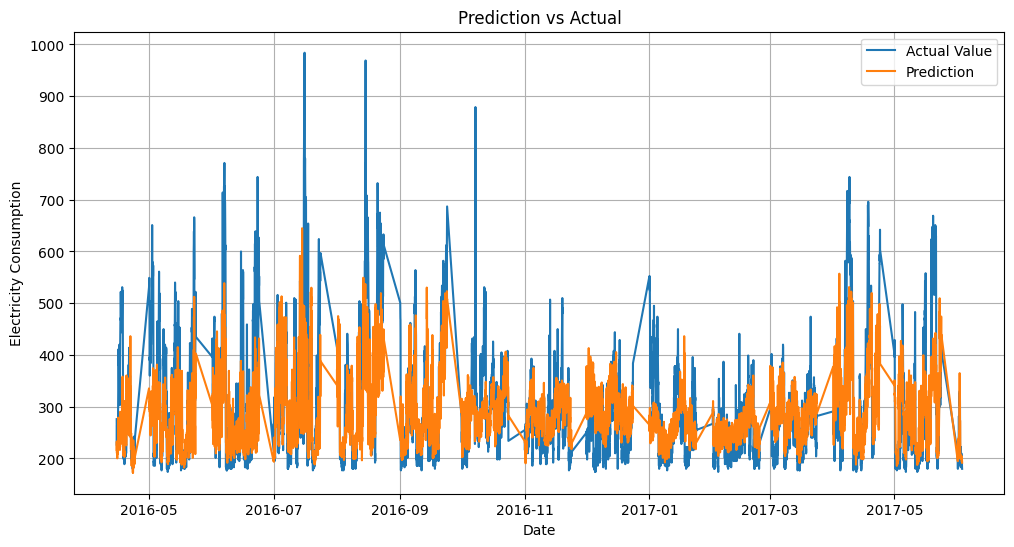

In [52]:
import matplotlib.pyplot as plt

y_test = pd.DataFrame(y_test)
y_test['predictions'] = best_model_predictions
X_test['datetime'] = pd.to_datetime(X_test[['year', 'month', 'day', 'hour']])
y_test['datetime'] = X_test['datetime']

y_test = y_test.sort_values(by='datetime')

plt.figure(figsize=(12, 6))

plt.plot(y_test['datetime'], y_test['electricity_consumption'], label='Actual Value')
plt.plot(y_test['datetime'], y_test['predictions'], label='Prediction')

plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.title('Prediction vs Actual')
plt.legend()
plt.grid(True)

plt.show()

# Compating performance in the validation set

In [53]:
models = [xg_reg, lgb_reg, regr]
model_name = ['XGBoost','LightGBM', 'RandomForest']
model_RMSE = []
model_predictions = []

for item in models:
  base_accuracy, predictions, RMSE = evaluate(item, X_pred, y_pred)
  model_RMSE.append(RMSE)
  model_predictions.append(predictions)

r = model_RMSE.index(min(model_RMSE))
best_model_predictions = model_predictions[r]
best_model_name = model_name[r]
best_model = models[r]


Model Performance
Average Error: 56.4895 degrees.
Accuracy = 80.23%.
RMSE = 80.37
Model Performance
Average Error: 43.6196 degrees.
Accuracy = 85.48%.
RMSE = 67.90
Model Performance
Average Error: 46.8309 degrees.
Accuracy = 83.58%.
RMSE = 71.68


In [54]:
print('Best Model:')
print(best_model_name)
print('Model Object:')
print(best_model)
print('Predictions:')
print(best_model_predictions)


Best Model:
LightGBM
Model Object:
LGBMRegressor(random_state=42)
Predictions:
[192.02849511 193.2968421  237.88839221 221.5189054  212.80355811
 206.80779746 207.37546971 207.14007037 208.5919119  205.05943497
 202.49199157 205.05943497 206.73860635 203.37080023 207.00436673
 204.19965083 233.34242302 238.22601053 229.43033946 217.36532302
 209.62031574 210.11428889 204.99864413 202.54362727 235.22940937
 221.95106969 225.34880764 222.14923335 225.23069969 217.34363158
 214.27011354 211.82848886 213.89049168 211.31789582 207.13325938
 232.87577214 231.06615227 235.98911853 255.70579284 254.29933613
 296.3633898  352.75764798 269.2324668  263.67953229 355.5478214
 359.1433237  306.64453897 283.07961304 328.32357687 328.09345003
 272.7926993  271.04794768 262.34072163 243.41526875 223.60502308
 217.63879732 250.8424193  237.80932361 242.9721742  232.71441757
 239.03637335 250.66858403 248.95450287 238.74039742 252.07948862
 314.62270119 296.32141252 292.02354448 250.9503676  300.6073805

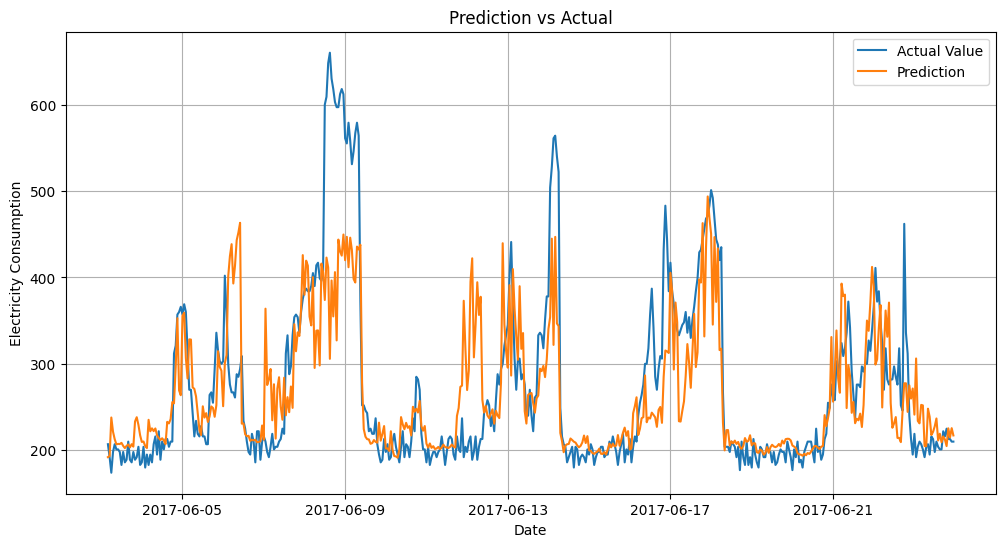

In [55]:
import matplotlib.pyplot as plt

y_pred = pd.DataFrame(y_pred)
y_pred['predictions'] = best_model_predictions
X_pred['datetime'] = pd.to_datetime(X_pred[['year', 'month', 'day', 'hour']])
y_pred['datetime'] = X_pred['datetime']

y_pred = y_pred.sort_values(by='datetime')

plt.figure(figsize=(12, 6))

plt.plot(y_pred['datetime'], y_pred['electricity_consumption'], label='Actual Value')
plt.plot(y_pred['datetime'], y_pred['predictions'], label='Prediction')

plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.title('Prediction vs Actual')
plt.legend()
plt.grid(True)

plt.show()